In [1]:
import warnings

warnings.filterwarnings("ignore")

import torch
import torch.backends.cuda
import torch.distributed as dist
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from torch.nn.parallel import DistributedDataParallel as DDP

import os
import random
import argparse
import json
import time
import itertools
import numpy as np
from tqdm import tqdm
from time import time
from copy import deepcopy
from accelerate import Accelerator
from torchvision import transforms
from transformers import CLIPImageProcessor, CLIPTokenizer, CLIPTextModel, CLIPVisionModelWithProjection
from diffusers import AutoencoderKL, UNet2DConditionModel
from PIL import Image

# local imports
from networks import NETWORKS
from optimers import OPTIMERS
from autoencs import AUTOENCS
from methodes import METHODES
from utilities import ImgLatentDataset
from utilities import create_logger, load_config
from utilities import set_seed, update_ema, remove_module_prefix, remove_module_all

from ip_adapter.ip_adapter import ImageProjModel
from ip_adapter.utils import is_torch2_available, get_generator
if is_torch2_available():
    from ip_adapter.attention_processor import IPAttnProcessor2_0 as IPAttnProcessor, AttnProcessor2_0 as AttnProcessor
else:
    from ip_adapter.attention_processor import IPAttnProcessor, AttnProcessor


class MyDataset(torch.utils.data.Dataset):

    def __init__(self, json_file, tokenizer, size=512, t_drop_rate=0.05, i_drop_rate=0.05, ti_drop_rate=0.05, image_root_path="", vae=None, compute_latent_stats=False):
        super().__init__()

        self.tokenizer = tokenizer
        self.size = size
        self.i_drop_rate = i_drop_rate
        self.t_drop_rate = t_drop_rate
        self.ti_drop_rate = ti_drop_rate
        self.image_root_path = image_root_path
        self.vae = vae

        self.data = json.load(open(json_file))

        self.transform = transforms.Compose([
            transforms.Resize(self.size, interpolation=transforms.InterpolationMode.BILINEAR),
            transforms.CenterCrop(self.size),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5]),
        ])
        self.clip_image_processor = CLIPImageProcessor()
        
        # Initialize latent statistics
        self._latent_mean = None
        self._latent_std = None
        self.latent_multiplier = 1.0
        
        # Compute latent statistics if requested
        if compute_latent_stats and vae is not None:
            self._compute_latent_statistics()
        
    def _compute_latent_statistics(self, sample_size=128, batch_size=16):
        """
        Compute mean and std of latent representations
        
        Args:
            sample_size: Number of samples to use for statistics computation
            batch_size: Batch size for processing
        """
        print("Computing latent statistics...")
        
        # Sample subset of data
        sample_indices = np.random.choice(len(self.data), 
                                        min(sample_size, len(self.data)), 
                                        replace=False)
        
        latents = []
        
        # Temporarily disable dropout for consistent statistics
        original_i_drop = self.i_drop_rate
        original_t_drop = self.t_drop_rate
        original_ti_drop = self.ti_drop_rate
        self.i_drop_rate = 0.0
        self.t_drop_rate = 0.0
        self.ti_drop_rate = 0.0
        
        self.vae.eval()
        with torch.no_grad():
            for i in tqdm(range(0, len(sample_indices), batch_size), desc="Computing latent stats"):
                batch_indices = sample_indices[i:i+batch_size]
                batch_images = []
                
                for idx in batch_indices:
                    item = self.__getitem__(idx)
                    batch_images.append(item["image"])
                
                # Stack batch
                batch_tensor = torch.stack(batch_images).to(self.vae.device, dtype=self.vae.dtype)
                
                posterior = self.vae.encode(batch_tensor).latent_dist
                batch_latents = posterior.sample()  # or posterior.mean
                
                latents.append(batch_latents.cpu())
        
        # Restore original dropout rates
        self.i_drop_rate = original_i_drop
        self.t_drop_rate = original_t_drop
        self.ti_drop_rate = original_ti_drop
        
        # Concatenate all latents
        all_latents = torch.cat(latents, dim=0)
        print(f"Dimensions of all latents: {all_latents.shape}")
        
        # Compute statistics
        # Flatten spatial dimensions but keep channel dimension
        # Shape: [N, C, H, W] -> [1, C, 1, 1]
        self._latent_mean = all_latents.mean(dim=[0, 2, 3], keepdim=True)  # [1, C, 1, 1]
        self._latent_std = all_latents.std(dim=[0, 2, 3], keepdim=True)  # [1, C, 1, 1]

        # Prevent division by zero
        self._latent_std = torch.clamp(self._latent_std, min=1e-6)
        
        # Set latent multiplier (can be tuned based on your needs)
        self.latent_multiplier = 1.0 / self._latent_std.mean().item()
        
        print(f"Latent mean shape: {self._latent_mean.shape}")
        print(f"Latent std shape: {self._latent_std.shape}")
        print(f"Latent multiplier: {self.latent_multiplier}")
        print(f"Mean of latent mean: {self._latent_mean.mean().item():.6f}")
        print(f"Mean of latent std: {self._latent_std.mean().item():.6f}")

    def get_latent_stats_cuda(self):
        """
        Return latent statistics on CUDA
        """
        if self._latent_mean is None or self._latent_std is None:
            raise ValueError("Latent statistics not computed. Set compute_latent_stats=True during initialization.")
        
        return (
            self._latent_mean.cuda(),
            self._latent_std.cuda(),
            self.latent_multiplier
        )
    
    def save_latent_stats(self, filepath):
        """
        Save latent statistics to file
        """
        if self._latent_mean is None or self._latent_std is None:
            raise ValueError("No latent statistics to save.")
        
        torch.save({
            'latent_mean': self._latent_mean,
            'latent_std': self._latent_std,
            'latent_multiplier': self.latent_multiplier
        }, filepath)
        print(f"Latent statistics saved to {filepath}")
    
    def load_latent_stats(self, filepath):
        """
        Load latent statistics from file
        """
        stats = torch.load(filepath, map_location='cpu')
        self._latent_mean = stats['latent_mean']
        self._latent_std = stats['latent_std']
        self.latent_multiplier = stats['latent_multiplier']
        print(f"Latent statistics loaded from {filepath}")

    def __getitem__(self, idx):
        item = self.data[idx] 
        text = item["text"]
        image_file = item["image_file"]
        
        # read image
        raw_image = Image.open(os.path.join(self.image_root_path, image_file))
        image = self.transform(raw_image.convert("RGB"))
        clip_image = self.clip_image_processor(images=raw_image, return_tensors="pt").pixel_values
        
        # drop
        drop_image_embed = 0
        rand_num = random.random()
        if rand_num < self.i_drop_rate:
            drop_image_embed = 1
        elif rand_num < (self.i_drop_rate + self.t_drop_rate):
            text = ""
        elif rand_num < (self.i_drop_rate + self.t_drop_rate + self.ti_drop_rate):
            text = ""
            drop_image_embed = 1
        # get text and tokenize
        text_input_ids = self.tokenizer(
            text,
            max_length=self.tokenizer.model_max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        ).input_ids
        
        return {
            "image": image,
            "text_input_ids": text_input_ids,
            "clip_image": clip_image,
            "drop_image_embed": drop_image_embed
        }

    def __len__(self):
        return len(self.data)
    

def collate_fn(data):
    images = torch.stack([example["image"] for example in data])
    text_input_ids = torch.cat([example["text_input_ids"] for example in data], dim=0)
    clip_images = torch.cat([example["clip_image"] for example in data], dim=0)
    drop_image_embeds = [example["drop_image_embed"] for example in data]

    return {
        "images": images,
        "text_input_ids": text_input_ids,
        "clip_images": clip_images,
        "drop_image_embeds": drop_image_embeds
    }
    

class IPAdapter(torch.nn.Module):
    """IP-Adapter"""
    def __init__(self, unet, image_proj_model, adapter_modules, ckpt_path=None):
        super().__init__()
        self.unet = unet
        self.image_proj_model = image_proj_model
        self.adapter_modules = adapter_modules

        if ckpt_path is not None:
            self.load_from_checkpoint(ckpt_path)
    
    def get_encoder_hidden_states(self, text_embeds, image_embeds):
        """
        Get encoder hidden states with image embeddings projected by image_proj_model.
        """
        ip_tokens = self.image_proj_model(image_embeds)
        encoder_hidden_states = torch.cat([text_embeds, ip_tokens], dim=1)
        return encoder_hidden_states
    
    def forward(self, noisy_latents, timesteps, encoder_hidden_states):
        """
        Forward pass for the IP-Adapter.
        Args:
            noisy_latents: Noisy latents input to the UNet.
            timesteps: Timesteps for the diffusion process.
            encoder_hidden_states: Text embeddings concatenated with image embeddings projected by image_proj_model.
        Returns:
            noise_pred: Predicted noise residual from the UNet.
        """
        # Predict the noise residual
        noise_pred = self.unet(noisy_latents, timesteps, encoder_hidden_states).sample
        return noise_pred

    def load_from_checkpoint(self, ckpt_path: str):
        # Calculate original checksums
        orig_ip_proj_sum = torch.sum(torch.stack([torch.sum(p) for p in self.image_proj_model.parameters()]))
        orig_adapter_sum = torch.sum(torch.stack([torch.sum(p) for p in self.adapter_modules.parameters()]))

        state_dict = torch.load(ckpt_path, map_location="cpu")

        # Load state dict for image_proj_model and adapter_modules
        self.image_proj_model.load_state_dict(state_dict["image_proj"], strict=True)
        self.adapter_modules.load_state_dict(state_dict["ip_adapter"], strict=True)

        # Calculate new checksums
        new_ip_proj_sum = torch.sum(torch.stack([torch.sum(p) for p in self.image_proj_model.parameters()]))
        new_adapter_sum = torch.sum(torch.stack([torch.sum(p) for p in self.adapter_modules.parameters()]))

        # Verify if the weights have changed
        assert orig_ip_proj_sum != new_ip_proj_sum, "Weights of image_proj_model did not change!"
        assert orig_adapter_sum != new_adapter_sum, "Weights of adapter_modules did not change!"

        print(f"Successfully loaded weights from checkpoint {ckpt_path}")


def get_model(train_config, accelerator):
    pretrained_model_name_or_path = train_config['model']["pretrained_model_name_or_path"]
    image_encoder_path = train_config['model']["image_encoder_path"]
    tokenizer = CLIPTokenizer.from_pretrained(pretrained_model_name_or_path, subfolder="tokenizer")
    text_encoder = CLIPTextModel.from_pretrained(pretrained_model_name_or_path, subfolder="text_encoder")
    vae = AutoencoderKL.from_pretrained(pretrained_model_name_or_path, subfolder="vae")
    unet = UNet2DConditionModel.from_pretrained(pretrained_model_name_or_path, subfolder="unet")
    image_encoder = CLIPVisionModelWithProjection.from_pretrained(image_encoder_path)
    # freeze parameters of models to save more memory
    # unet.requires_grad_(False)
    vae.requires_grad_(False)
    text_encoder.requires_grad_(False)
    image_encoder.requires_grad_(False)

    # ip-adapter
    image_proj_model = ImageProjModel(
        cross_attention_dim=unet.config.cross_attention_dim,
        clip_embeddings_dim=image_encoder.config.projection_dim,
        clip_extra_context_tokens=4,
    )
    # init adapter modules
    attn_procs = {}
    unet_sd = unet.state_dict()
    for name in unet.attn_processors.keys():
        cross_attention_dim = None if name.endswith("attn1.processor") else unet.config.cross_attention_dim
        if name.startswith("mid_block"):
            hidden_size = unet.config.block_out_channels[-1]
        elif name.startswith("up_blocks"):
            block_id = int(name[len("up_blocks.")])
            hidden_size = list(reversed(unet.config.block_out_channels))[block_id]
        elif name.startswith("down_blocks"):
            block_id = int(name[len("down_blocks.")])
            hidden_size = unet.config.block_out_channels[block_id]
        if cross_attention_dim is None:
            attn_procs[name] = AttnProcessor()
        else:
            layer_name = name.split(".processor")[0]
            weights = {
                "to_k_ip.weight": unet_sd[layer_name + ".to_k.weight"],
                "to_v_ip.weight": unet_sd[layer_name + ".to_v.weight"],
            }
            attn_procs[name] = IPAttnProcessor(hidden_size=hidden_size, cross_attention_dim=cross_attention_dim)
            attn_procs[name].load_state_dict(weights)
    unet.set_attn_processor(attn_procs)
    adapter_modules = torch.nn.ModuleList(unet.attn_processors.values())
    
    ip_adapter = IPAdapter(unet, image_proj_model, adapter_modules, train_config['model']["pretrained_ip_adapter_path"])
    ip_adapter.requires_grad_(False)
    
    weight_dtype = torch.float16
    # if accelerator.mixed_precision == "fp16":
    #     weight_dtype = torch.float16
    # elif accelerator.mixed_precision == "bf16":
    #     weight_dtype = torch.bfloat16
    # unet.to(accelerator.device, dtype=weight_dtype)
    vae.to(accelerator.device, dtype=weight_dtype)
    text_encoder.to(accelerator.device, dtype=weight_dtype)
    image_encoder.to(accelerator.device, dtype=weight_dtype)
    # add
    unet.to(accelerator.device, dtype=weight_dtype)
    image_proj_model.to(accelerator.device, dtype=weight_dtype)
    ip_adapter.to(accelerator.device, dtype=weight_dtype)


    # params_to_opt = itertools.chain(ip_adapter.image_proj_model.parameters(),  ip_adapter.adapter_modules.parameters())
    params_to_opt = itertools.chain(unet.parameters())

    return ip_adapter, params_to_opt, tokenizer, vae, text_encoder, image_encoder

In [2]:

torch.cuda.empty_cache()

# read config
import os
os.environ["NCCL_P2P_DISABLE"] = "1"
os.environ["NCCL_IB_DISABLE"] = "1"

args_config = "./configs/tuning_few_steps/in1k256_sd15_klae_linear.yaml"
accelerator = Accelerator()
train_config = load_config(args_config)
par_path = args_config.split("/")
train_config["exp_name"] = os.path.join(par_path[-2], par_path[-1].split(".")[0])

print(f"Using config: {args_config}")
print(train_config)


"""
Training a generative model.
"""
# Setup accelerator:
device = accelerator.device
rank = accelerator.process_index
seed = train_config["train"]["global_seed"] * accelerator.num_processes + rank
set_seed(seed)

experiment_dir = f"{train_config['output_dir']}/{train_config['exp_name']}"
checkpoint_dir = f"{experiment_dir}/checkpoints"

# Setup an experiment folder:
if accelerator.is_main_process:
    os.makedirs(train_config["output_dir"], exist_ok=True)
    os.makedirs(checkpoint_dir, exist_ok=True)
    logger = create_logger(experiment_dir, "train")
    logger.info(f"Experiment directory created at {experiment_dir}")

# Create model:
downsample_ratio = train_config["vae"]["downsample_ratio"]
assert (
    train_config["data"]["image_size"] % downsample_ratio == 0
), "Image size must be divisible by 8 (for the VAE encoder)."
latent_size = train_config["data"]["image_size"] // downsample_ratio

# Load scheduler, tokenizer and models.
model, params_to_opt, tokenizer, vae, text_encoder, image_encoder = get_model(train_config, accelerator)
model = model.to(device)
params_to_opt_list = list(params_to_opt)
print(f"[{rank}] {len(params_to_opt_list)}, params to optimize")

ema = deepcopy(model).requires_grad_(False).to(device)

if accelerator.is_main_process:
    demoimages_dir = f"{experiment_dir}/demoimages"
    os.makedirs(demoimages_dir, exist_ok=True)

unigen = METHODES["unigen"](
    transport_type=train_config["transport"]["type"],
    lab_drop_ratio=train_config["transport"]["lab_drop_ratio"],
    consistc_ratio=train_config["transport"]["consistc_ratio"],
    enhanced_ratio=train_config["transport"]["enhanced_ratio"],
    enhanced_style=train_config["transport"]["enhanced_style"],
    scaled_cbl_eps=train_config["transport"]["scaled_cbl_eps"],
    ema_decay_rate=train_config["transport"]["ema_decay_rate"],
    enhanced_range=train_config["transport"]["enhanced_range"],
    time_dist_ctrl=train_config["transport"]["time_dist_ctrl"],
    wt_cosine_loss=train_config["transport"]["wt_cosine_loss"],
    weight_funcion=train_config["transport"]["weight_funcion"],
)
if accelerator.is_main_process:
    logger.info(
        f"SD15 parameters: {sum(p.numel() for p in params_to_opt_list) / 1e6:.2f}M"
    )
    logger.info(
        f"Optimizer: {train_config['optimizer']['type']}, lr={train_config['optimizer']['lr']}, beta1={train_config['optimizer']['beta1']}, beta2={train_config['optimizer']['beta2']}"
    )
    logger.info(f'Use cosine loss: {train_config["transport"]["wt_cosine_loss"]}')
    logger.info(f'Use weight func: {train_config["transport"]["weight_funcion"]}')

opt = OPTIMERS[train_config["optimizer"]["type"]](
    params_to_opt_list,
    lr=train_config["optimizer"]["lr"],
    weight_decay=train_config["optimizer"]["weight_decay"],
    betas=(train_config["optimizer"]["beta1"], train_config["optimizer"]["beta2"]),
)

# tokenizer = CLIPTokenizer.from_pretrained(args.pretrained_model_name_or_path, subfolder="tokenizer")
dataset = MyDataset(
    json_file=train_config["data"]["json_file"],
    tokenizer=tokenizer,
    size=train_config["data"]["image_size"],
    image_root_path=train_config["data"]["image_root_path"],
    vae=vae,
    compute_latent_stats=True,
)

batch_size_per_gpu = (
    train_config["train"]["global_batch_size"] // accelerator.num_processes
)

global_batch_size = batch_size_per_gpu * accelerator.num_processes
loader = DataLoader(
    dataset,
    batch_size=batch_size_per_gpu,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=train_config["data"]["num_workers"],
    pin_memory=True,
    drop_last=True,
)

if accelerator.is_main_process:
    mean, stad, latent_multiplier = (
        dataset._latent_mean.cuda(),
        dataset._latent_std.cuda(),
        dataset.latent_multiplier,
    )
    # logger.info(
    #     f"Dataset contains {len(dataset):,} images {train_config['data']['data_path']}"
    # )
    logger.info(
        f"Batch size {batch_size_per_gpu} per gpu, with {global_batch_size} global batch size"
    )

if "ckpt" in train_config["train"]:
    checkpoint_path = f"{checkpoint_dir}/{train_config['train']['ckpt']}"
    checkpoint = torch.load(
        checkpoint_path, map_location=lambda storage, loc: storage
    )
    model.load_state_dict(checkpoint["model"])
    if train_config["train"]["no_reopt"] is not True:
        opt.load_state_dict(checkpoint["opt"])
    if train_config["train"]["no_reuni"] is not True:
        if ((unigen.cor > 0.0) or (unigen.enr > 0.0)) and unigen.emd > 0.0:
            unigen.mod = deepcopy(model).requires_grad_(False).to(device)
        unigen.load_state_dict(checkpoint["unigen"])
    ema.load_state_dict(checkpoint["ema"])
    train_steps = int(checkpoint_path.split("/")[-1].split(".")[0])
    del checkpoint
    if accelerator.is_main_process:
        logger.info(f"Loaded checkpoint at: {checkpoint_path}.")
else:
    train_steps = 0
    update_ema(ema, model, decay=0)
    if accelerator.is_main_process:
        logger.info("Starting training from scratch.")

# Prepare models for training:
model.train()
ema.eval()
if train_config["train"]["no_buffer"] is True:
    model = DDP(model, device_ids=[rank], broadcast_buffers=False)
model, opt, loader, unigen = accelerator.prepare(model, opt, loader, unigen)

# Variables for monitoring/logging purposes:
log_steps = 0
running_loss = 0
start_time = time()

while True:
    for batch in loader:
        # Convert images to latent space
        with torch.no_grad():
            latents = vae.encode(batch["images"].to(accelerator.device, dtype=vae.dtype)).latent_dist.sample()
            latents = latents * vae.config.scaling_factor

            image_embeds = image_encoder(batch["clip_images"].to(accelerator.device, dtype=image_encoder.dtype)).image_embeds
            text_embeds = text_encoder(batch["text_input_ids"].to(accelerator.device))[0]

        image_embeds_ = []
        for image_embed, drop_image_embed in zip(image_embeds, batch["drop_image_embeds"]):
            if drop_image_embed == 1:
                image_embeds_.append(torch.zeros_like(image_embed))
            else:
                image_embeds_.append(image_embed)
        image_embeds = torch.stack(image_embeds_)

        x = latents
        y = model.get_encoder_hidden_states(text_embeds, image_embeds)

        loss = unigen.training_step(model, x, y)

        opt.zero_grad()
        accelerator.backward(loss)
        if "max_grad_norm" in train_config["optimizer"]:
            if accelerator.sync_gradients:
                accelerator.clip_grad_norm_(
                    model.parameters(), train_config["optimizer"]["max_grad_norm"]
                )
        for param in model.parameters():
            if param.grad is not None:
                torch.nan_to_num_(param.grad, nan=0.0, posinf=0.0, neginf=0.0)
        opt.step()
        update_ema(ema, model, train_config["train"]["ema_decay"])

        # Log loss values:
        running_loss += loss.item()
        log_steps += 1
        train_steps += 1
        if train_steps % train_config["train"]["log_every"] == 0:
            # Measure training speed:
            torch.cuda.synchronize()
            end_time = time()
            steps_per_sec = log_steps / (end_time - start_time)
            # Reduce loss history over all processes:
            avg_loss = torch.tensor(running_loss / log_steps, device=device)
            dist.all_reduce(avg_loss, op=dist.ReduceOp.SUM)
            avg_loss = avg_loss.item() / dist.get_world_size()
            if accelerator.is_main_process:
                logger.info(
                    f"(step={train_steps:07d}) Train Loss: {avg_loss:.4f}, Train Steps/Sec: {steps_per_sec:.2f}"
                )
            # Reset monitoring variables:
            running_loss = 0
            log_steps = 0
            start_time = time()

        # Save checkpoint:
        if (
            train_steps % train_config["train"]["ckpt_every"] == 0
            and train_steps > 0
        ):
            if accelerator.is_main_process:
                checkpoint = {
                    "model": remove_module_prefix(model.state_dict()),
                    "ema": ema.state_dict(),
                    "opt": opt.state_dict(),
                    "unigen": remove_module_all(unigen.state_dict()),
                    "config": train_config,
                }
                checkpoint_path = f"{checkpoint_dir}/{train_steps:07d}.pt"
                torch.save(checkpoint, checkpoint_path)
                logger.info(f"Saved checkpoint to {checkpoint_path}")

            # dist.barrier()

        if train_steps >= train_config["train"]["max_steps"]:
            break
    if train_steps >= train_config["train"]["max_steps"]:
        break
if accelerator.is_main_process:
    logger.info("Done!")



INFO: Experiment directory created at ./outputs/tuning_few_steps/in1k256_sd15_klae_linear


Using config: ./configs/tuning_few_steps/in1k256_sd15_klae_linear.yaml
{'output_dir': './outputs', 'data': {'json_file': './sd_data_2k/captions.json', 'image_size': 512, 'image_root_path': './sd_data_2k', 'num_workers': 8}, 'vae': {'type': 'klae_ema_f8c4', 'downsample_ratio': 8}, 'model': {'pretrained_model_name_or_path': '/data/pretrained_models/stable-diffusion-v1-5', 'image_encoder_path': '/data/pretrained_models/IP-Adapter/models/image_encoder', 'pretrained_ip_adapter_path': '/data/pretrained_models/IP-Adapter/models/ip-adapter_sd15.bin'}, 'train': {'no_reopt': True, 'no_reuni': True, 'no_buffer': False, 'max_steps': 1, 'global_batch_size': 32, 'global_seed': 0, 'log_every': 50, 'ckpt_every': 1, 'ema_decay': 0.99}, 'optimizer': {'type': 'RAdam', 'lr': 0.0001, 'weight_decay': 0.0, 'beta1': 0.9, 'beta2': 0.999, 'max_grad_norm': 0.1}, 'transport': {'type': 'DDIM', 'lab_drop_ratio': 0.1, 'consistc_ratio': 0.0, 'enhanced_ratio': 0.0, 'enhanced_style': None, 'scaled_cbl_eps': 0.0, 'ema_d

INFO: SD15 parameters: 878.69M
INFO: Optimizer: RAdam, lr=0.0001, beta1=0.9, beta2=0.999
INFO: Use cosine loss: False
INFO: Use weight func: None


[0] 718, params to optimize
Computing latent statistics...


Computing latent stats: 100%|██████████| 8/8 [00:04<00:00,  1.71it/s]
INFO: Batch size 32 per gpu, with 32 global batch size
INFO: Starting training from scratch.


Dimensions of all latents: torch.Size([128, 4, 64, 64])
Latent mean shape: torch.Size([1, 4, 1, 1])
Latent std shape: torch.Size([1, 4, 1, 1])
Latent multiplier: 0.22107081174438686
Mean of latent mean: 0.339600
Mean of latent std: 4.523438


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [ ]:
model

IPAdapter(
  (unet): UNet2DConditionModel(
    (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (time_proj): Timesteps()
    (time_embedding): TimestepEmbedding(
      (linear_1): Linear(in_features=320, out_features=1280, bias=True)
      (act): SiLU()
      (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
    )
    (down_blocks): ModuleList(
      (0): CrossAttnDownBlock2D(
        (attentions): ModuleList(
          (0-1): 2 x Transformer2DModel(
            (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
            (proj_in): Conv2d(320, 320, kernel_size=(1, 1), stride=(1, 1))
            (transformer_blocks): ModuleList(
              (0): BasicTransformerBlock(
                (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
                (attn1): Attention(
                  (to_q): Linear(in_features=320, out_features=320, bias=False)
                  (to_k): Linear(in_features=320, out_features=320, bias=Fa

In [ ]:
from transformers import CLIPImageProcessor, CLIPVisionModelWithProjection


image = Image.open("/home/ccy/code/IP-Adapter/assets/images/river.png").convert("RGB")
clip_image_processor = CLIPImageProcessor()
clip_image = clip_image_processor(images=image, return_tensors="pt").pixel_values
clip_image_embeds = image_encoder(clip_image.to(device, dtype=vae.dtype)).image_embeds
# repeat 4 times
num_samples = 2
guidance_scale = 7.5
sampling_steps = 50
# clip_image_embeds = clip_image_embeds.repeat(4, 1, 1)

# generate prompts
num_prompts = clip_image_embeds.size(0)
prompt = ["best quality, high quality"] * num_prompts
negative_prompt = ["monochrome, lowres, bad anatomy, worst quality, low quality"] * num_prompts
batch_size = len(prompt) if isinstance(prompt, list) else 1

# encode image prompts
image_prompt_embeds = model.image_proj_model(clip_image_embeds)
uncond_image_prompt_embeds = model.image_proj_model(torch.zeros_like(clip_image_embeds))
bs_embed, seq_len, _ = image_prompt_embeds.shape
image_prompt_embeds = image_prompt_embeds.repeat(1, num_samples, 1).view(bs_embed * num_samples, seq_len, -1)
uncond_image_prompt_embeds = uncond_image_prompt_embeds.repeat(1, num_samples, 1).view(bs_embed * num_samples, seq_len, -1)

# encode text prompts
text_input_ids = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt").input_ids
if text_input_ids.shape[-1] > tokenizer.model_max_length:
    text_input_ids = text_input_ids[:, :tokenizer.model_max_length]
uncond_input_ids = tokenizer(negative_prompt, padding="max_length", max_length=text_input_ids.shape[-1], truncation=True, return_tensors="pt").input_ids

text_prompt_embeds = text_encoder(text_input_ids.to(device))[0]
text_prompt_embeds = text_prompt_embeds.repeat(1, num_samples, 1).view(batch_size * num_samples, -1, text_prompt_embeds.shape[-1])
text_negative_prompt_embeds = text_encoder(uncond_input_ids.to(device))[0]
text_negative_prompt_embeds = text_negative_prompt_embeds.repeat(1, num_samples, 1).view(batch_size * num_samples, -1, text_negative_prompt_embeds.shape[-1])

# concat prompt
prompt_embeds = torch.cat([text_prompt_embeds, image_prompt_embeds], dim=1)
negative_prompt_embeds = torch.cat([text_negative_prompt_embeds, uncond_image_prompt_embeds], dim=1)

def cfg_model_wrapper(x_t, t, negative_prompt_embeds, prompt_embeds):
    # Expand the latents for classifier-free guidance
    if guidance_scale > 1.0:
        latent_model_input = torch.cat([x_t] * 2)
        encoder_hidden_states = torch.cat([negative_prompt_embeds, prompt_embeds])
        t = t.repeat(2)  # Repeat t for both unconditioned and conditioned inputs
    else:
        latent_model_input = x_t
        encoder_hidden_states = prompt_embeds
    
    # Predict noise
    noise_pred = model.unet(
        latent_model_input,
        t * 1000,   # scale t to match the model's expected input
        encoder_hidden_states=encoder_hidden_states,
        return_dict=False,
    )[0]
    
    # Apply classifier-free guidance
    if guidance_scale > 1.0:
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
    
    return noise_pred

# generator = get_generator(seed, device)
with torch.inference_mode():
    generator = get_generator(seed, device)
    latent_channels = model.unet.config.in_channels
    latents = torch.randn(
        (num_prompts * num_samples, latent_channels, latent_size, latent_size),
        device=device,
        generator=generator,
        dtype=vae.dtype
    )

    samples = unigen.sampling_loop(
        inital_noise_z=latents,
        sampling_model=cfg_model_wrapper,
        sampling_steps=sampling_steps,
        stochast_ratio=0.0,
        extrapol_ratio=0.0,
        sampling_order=1,
        time_dist_ctrl=[1.0, 1.0, 1.0],
        rfba_gap_steps=[0.019, 0.001],
        prompt_embeds=prompt_embeds,
        negative_prompt_embeds=negative_prompt_embeds,
    )
    print(f"Samples shape: {samples.shape}, dtype: {samples.dtype}")
    samples = samples[1::2].reshape(-1, *samples.shape[2:])
    print(f"Samples shape: {samples.shape}, dtype: {samples.dtype}")
    with torch.no_grad():
        # samples = (samples * dataset._latent_std.cuda()) / dataset.latent_multiplier + dataset._latent_mean.cuda()
        samples = samples / vae.config.scaling_factor
        samples = vae.decode(samples).sample
        samples = torch.clamp((samples + 1) / 2, 0, 1)
    save_image(samples, f"{demoimages_dir}/sampled_images.png", nrow=num_samples)
    print(f"Sampled images saved to {demoimages_dir}/sampled_images.png")


time steps: tensor([9.8096e-01, 9.6094e-01, 9.4092e-01, 9.2090e-01, 9.0088e-01, 8.8086e-01,
        8.6084e-01, 8.4082e-01, 8.2129e-01, 8.0078e-01, 7.8125e-01, 7.6074e-01,
        7.4121e-01, 7.2070e-01, 7.0117e-01, 6.8066e-01, 6.6113e-01, 6.4111e-01,
        6.2109e-01, 6.0107e-01, 5.8105e-01, 5.6104e-01, 5.4102e-01, 5.2100e-01,
        5.0098e-01, 4.8096e-01, 4.6094e-01, 4.4092e-01, 4.2090e-01, 4.0088e-01,
        3.8086e-01, 3.6084e-01, 3.4082e-01, 3.2080e-01, 3.0078e-01, 2.8076e-01,
        2.6123e-01, 2.4121e-01, 2.2119e-01, 2.0117e-01, 1.8115e-01, 1.6113e-01,
        1.4111e-01, 1.2109e-01, 1.0107e-01, 8.1055e-02, 6.1035e-02, 4.1016e-02,
        2.0996e-02, 9.7656e-04, 0.0000e+00], device='cuda:0',
       dtype=torch.float16)
Samples shape: torch.Size([51, 2, 4, 64, 64]), dtype: torch.float16
Samples shape: torch.Size([50, 4, 64, 64]), dtype: torch.float16
Sampled images saved to ./outputs/tuning_few_steps/in1k256_sd15_klae_linear/demoimages/sampled_images.png


In [ ]:
print(samples.device)
print(samples.shape)
print(latents.dtype)
print(vae.config.scaling_factor)

cuda:0
torch.Size([50, 3, 512, 512])
torch.float16
0.18215


(50, 512, 512, 3)


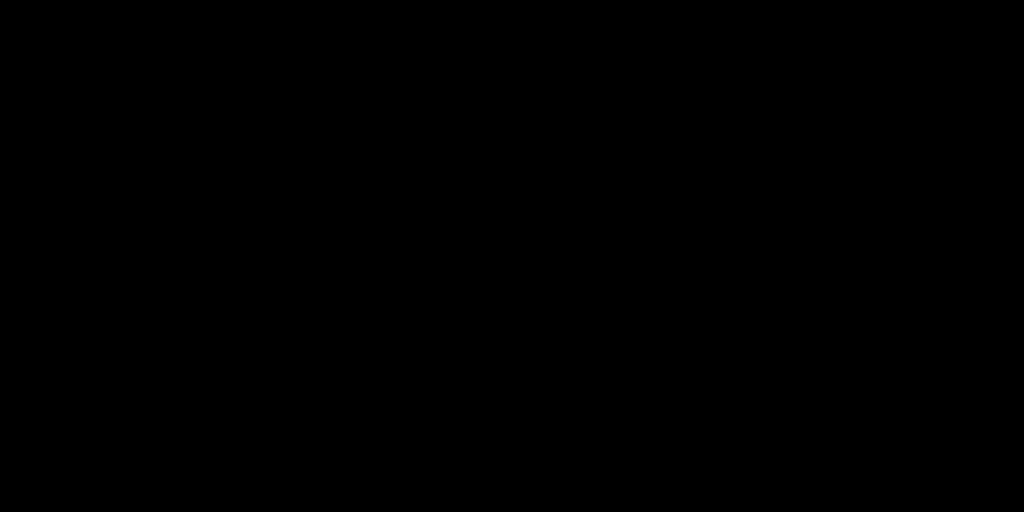

In [ ]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid



images = samples.cpu().permute(0, 2, 3, 1).numpy()
print(images.shape)
images = (images * 255).round().astype("uint8")
images = [Image.fromarray(image) for image in images]
image_grid(images[-num_samples*num_prompts:], 1, 2)
